# Getting started with DoWhy: A simple example
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and estimate the causal effect of a (pre-specified) treatment variable on a (pre-specified) outcome variable.

First, let us load all required packages.

In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=5000, 
        treatment_is_binary=True,
        stddev_treatment_noise=10,
        num_discrete_common_causes=1)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0        W1        W2        W3 W4    v0  \
0  1.585793  1.0  0.772471  1.242287  0.508133  0.083738  0.088576  2  True   
1  1.863596  1.0  0.581399  1.623811  0.950458 -0.572963  0.836689  1  True   
2  1.266947  1.0  0.785675 -0.477185 -1.729982  0.917488 -0.210789  2  True   
3  0.720418  1.0  0.719862 -2.256674  1.938412 -0.738299  0.873388  2  True   
4  1.283686  1.0  0.333020  0.546470  0.648651 -0.202055  1.132847  2  True   

           y  
0  26.880173  
1  29.203548  
2  14.467075  
3   5.630110  
4  22.202268  
digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ 

Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Interface 1 (recommended): Input causal graph

We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

To create the causal graph for your dataset, you can use a tool like [DAGitty](http://dagitty.net/dags.html#) that provides a GUI to construct the graph. You can export the graph string that it generates. The graph string is very close to the DOT format: just rename `dag` to `digraph`, remove newlines and add a semicolon after every line, to convert it to the DOT format and input to DoWhy. 

In [3]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

In [4]:
model.view_model()

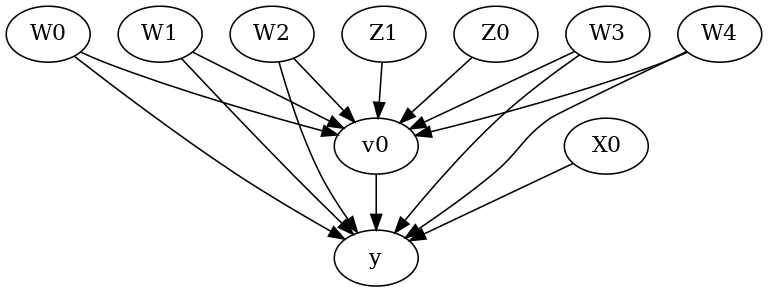

In [5]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify 
the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

### DoWhy philosophy: Keep identification and estimation separate

Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step.
It is important to understand that these are orthogonal steps.

#### Identification

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W4,W3,W2,U) = P(y|v0,W1,W0,W4,W3,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Note the parameter flag *proceed\_when\_unidentifiable*. It needs to be set to *True* to convey the assumption that we are ignoring any unobserved confounding. The default behavior is to prompt the user to double-check that the unobserved confounders can be ignored. 

#### Estimation

In [7]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W4,W3,W2,U) = P(y|v0,W1,W0,W4,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W4+W3+W2
Target units: ate

## Estimate
Mean value: 16.206932494838888

Causal Estimate is 16.206932494838888


You can input additional parameters to the estimate_effect method. For instance, to estimate the effect on any subset of the units, you can specify the "target_units" parameter which can be a string ("ate", "att", or "atc"), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. You can also specify "effect modifiers" to estimate heterogeneous effects across these variables. See `help(CausalModel.estimate_effect)`. 

In [8]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W4,W3,W2,U) = P(y|v0,W1,W0,W4,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W4+W3+W2
Target units: atc

## Estimate
Mean value: 16.453225579648844

Causal Estimate is 16.453225579648844


## Interface 2: Specify common causes and instruments

In [9]:
# Without graph                                       
model= CausalModel(                             
        data=df,                                      
        treatment=data["treatment_name"],             
        outcome=data["outcome_name"],                 
        common_causes=data["common_causes_names"],
        effect_modifiers=data["effect_modifier_names"])                         

In [10]:
model.view_model()

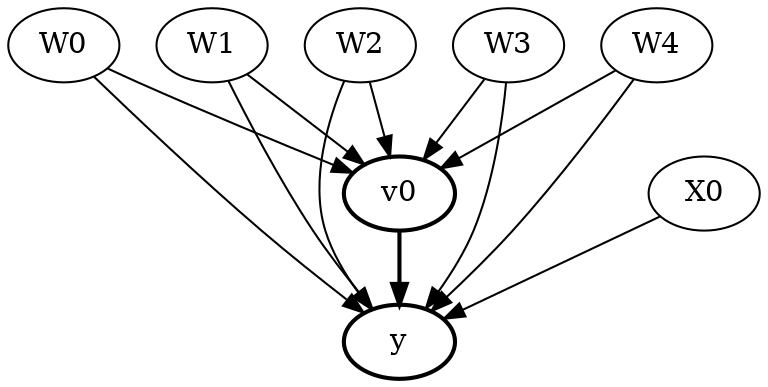

In [11]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get the same causal graph. Now identification and estimation is done as before.

#### Identification

In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)                         

#### Estimation

In [13]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")         
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W4,W3,W2,U) = P(y|v0,W1,W0,W4,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W4+W3+W2
Target units: ate

## Estimate
Mean value: 16.206932494838888

Causal Estimate is 16.206932494838888


## Refuting the estimate

Let us now look at ways of refuting the estimate obtained. Refutation methods provide tests that every correct estimator should pass. So if an estimator fails the refutation test (p-value is <0.05), then it means that there is some problem with the estimator. 

Note that we cannot verify that the estimate is correct, but we can reject it if it violates certain expected behavior (this is analogous to scientific theories that can be falsified but not proven true). The below refutation tests are based on either 
 1) **Invariant transformations**: changes in the data that should not change the estimate. Any estimator whose result varies significantly between the original data and the modified data fails the test; 
 
 a) Random Common Cause
 
 b) Data Subset
 
 
 2) **Nullifying transformations**: after the data change, the causal true estimate is zero. Any estimator whose result varies significantly from zero on the new data fails the test.
 
 a) Placebo Treatment

### Adding a random common cause variable

In [14]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:16.206932494838888
New effect:16.19378496905949
p value:1.0



### Replacing treatment with a random (placebo) variable

In [15]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:16.206932494838888
New effect:0.0014095935810505933
p value:0.98



### Removing a random subset of the data

In [16]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


Refute: Use a subset of data
Estimated effect:16.206932494838888
New effect:16.253211215504713
p value:0.8



As you can see, the propensity score stratification estimator is reasonably robust to refutations.
For reproducibility, you can add a parameter "random_seed" to any refutation method, as shown below.

In [17]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:16.206932494838888
New effect:16.2342347725428
p value:0.84



### Adding an unobserved common cause variable

This  refutation does not return a p-value. Instead, it provides a _sensitivity_ test on how quickly the estimate changes if the identifying assumptions (used in `identify_effect`) are not valid. Specifically, it checks sensitivity to violation of the  backdoor assumption: that all common causes are observed. 

To do so, it creates a new dataset with an additional common cause between treatment and outcome. To capture the effect of the common cause, the method takes as input the strength of common cause's effect on treatment and outcome. Based on these inputs on the common cause's effects, it changes the treatment and outcome values and then reruns the estimator. The hope is that the new estimate does not change drastically with a small effect of the unobserved common cause, indicating a robustness to any unobserved confounding.

Another equivalent way of interpreting this procedure is to assume that there was already unobserved confounding present in the input data. The change in treatment and outcome values _removes_ the effect of whatever unobserved common cause was present in the original data. Then rerunning the estimator on this modified data provides the correct identified estimate and we hope that the difference between the new estimate and the original estimate is not too high, for some bounded value of the unobserved common cause's effect.

**Importance of domain knowledge**: This test requires _domain knowledge_ to set plausible input values of the effect of unobserved confounding. We first show the result for a single value of confounder's effect on treatment and outcome.

In [18]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:16.206932494838888
New effect:11.762792980181827



It is often more useful to inspect the trend as the effect of unobserved confounding is increased. For that, we can provide an array of hypothesized confounders' effects. The output is the *(min, max)* range of the estimated effects under different unobserved confounding.

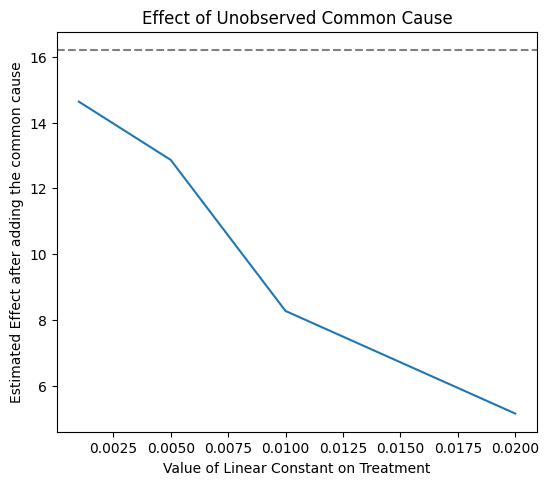

Refute: Add an Unobserved Common Cause
Estimated effect:16.206932494838888
New effect:(5.153779459325838, 14.634270871580327)



In [19]:
res_unobserved_range=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=np.array([0.001, 0.005, 0.01, 0.02]), effect_strength_on_outcome=0.01)
print(res_unobserved_range)

The above plot shows how the estimate decreases as the hypothesized confounding on treatment increases. By domain knowledge, we may know the maximum plausible confounding effect on treatment. Since we see that the effect does not go beyond zero, we can safely conclude that the causal effect of treatment `v0` is positive.

We can also vary the confounding effect on both treatment and outcome. We obtain a heatmap.

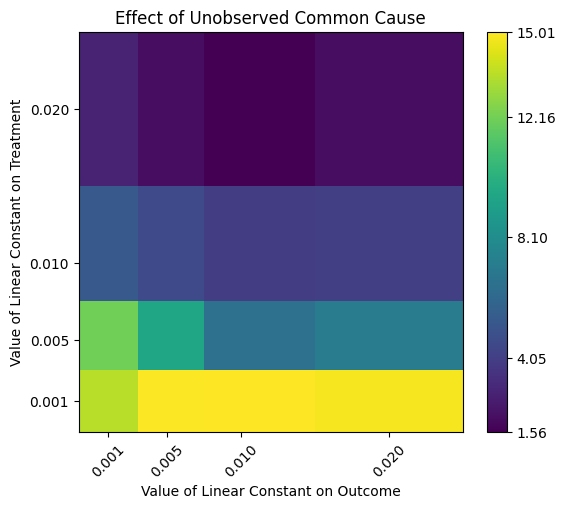

Refute: Add an Unobserved Common Cause
Estimated effect:16.206932494838888
New effect:(1.5558435707505949, 15.008200922012186)



In [20]:
res_unobserved_range=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                           effect_strength_on_treatment=[0.001, 0.005, 0.01, 0.02], 
                                           effect_strength_on_outcome=[0.001, 0.005, 0.01,0.02])
print(res_unobserved_range)

**Automatically inferring effect strength parameters.** Finally, DoWhy supports automatic selection of the effect strength parameters. This is based on an assumption that the effect of the unobserved confounder on treatment or outcome cannot be stronger than that of any observed confounder. That is, we have collected data at least for the most relevant confounder. If that is the case, then we can bound the range of `effect_strength_on_treatment` and `effect_strength_on_outcome` by the effect strength of observed confounders. There is an additional optional parameter signifying whether the effect strength of unobserved confounder should be as high as the highest observed, or a fraction of it. You can set it using the optional `effect_fraction_on_treatment` and `effect_fraction_on_outcome` parameters. By default, these two parameters are 1.

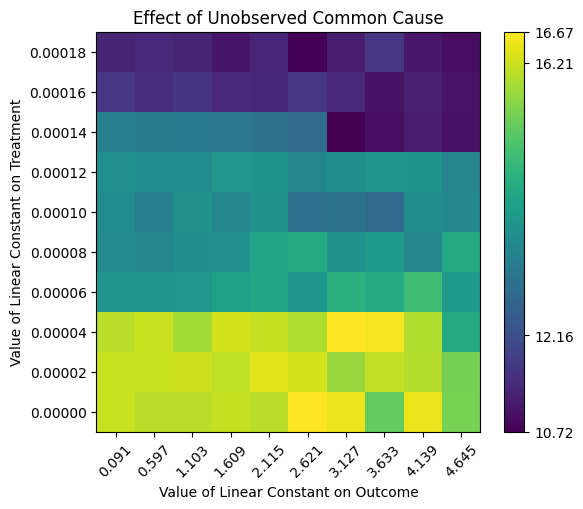

Refute: Add an Unobserved Common Cause
Estimated effect:16.206932494838888
New effect:(10.724303606038236, 16.671943217714034)



In [21]:
res_unobserved_auto = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear")
print(res_unobserved_auto)

**Conclusion**: Assuming that the unobserved confounder does not affect the treatment or outcome more strongly than any observed confounder, the causal effect can be concluded to be positive.